# Data analysis and processing
The goal of this notebook is to create and **store a dataframe with various relevant features**, that are potentially valuable for the DNN. Generally the features can be devided into weather features, time features, and Lag Features. 

In Detail we consider: 
- **Weather Features x9**: 'temp', 'rhum', 'dwpt', 'wdir', 'wspd', 'pres' + Principal component analysis x3
- **Time Features x10**: 'hour', 'dayofweek', 'month', 'year', 'hour sin', 'hour cos', 'Hour sin cos', 'dayofweek sin', 'dayofweek cos', 'dayofweek sin cos'
- **LAG Features x7**: (Shifted electricity consumption): Shifted by 24, 48, 78, 96, 120, 144, 168 hours

Based on the generated features, we calculate pearson and spearman correlation and select only features with an average correlation >0.1 over all Users, as this indicated at least los/ weak correlation. 

As a **Result** we consider the following features: 
- ['hour sin', 'hour cos']
- ['temp', 'rhum', 'wspd', 'PC1']
- [36 User x 7 Lags]

In [1]:
#Imports
#Data handling
import pandas as pd
#Create data arrays
import numpy as np
#Machine learning models
import tensorflow as tf
#Plotting
import matplotlib.pyplot as plt
#Create Folder for modelling checkpoint
import os
#Normalization
from sklearn.preprocessing import MinMaxScaler

#Won .py file with deep learning models
from utils.modelgenerator import *
#For svm model
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras import layers, models

import seaborn as sns

In [2]:
#Get data 
cwd = os.path.normpath(os.getcwd())
df = pd.read_csv(cwd+'/data/final_data/final_dataset.csv', index_col='Date') #df = pd.read_csv('user5.csv')
df.index = pd.to_datetime(df.index)
#df = df[['User5', 'temp', 'rhum']]
df.fillna(0, inplace=True)
df.head(3)

,User1,User10,User11,User12,User13,User14,User15,User16,User17,User18,...,User6,User7,User8,User9,temp,dwpt,rhum,wdir,wspd,pres
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,0.068,0.703,0.353,0.210,0.138,0.208,0.065,0.340,0.129,0.576,...,0.636,0.106,0.156,0.012,5.1,4.5,96.0,0.0,0.0,1015.2
2012-07-01 01:00:00,0.786,0.036,0.547,0.197,0.343,0.176,0.067,0.508,0.121,0.128,...,0.253,0.098,0.151,0.022,5.1,4.5,96.0,0.0,0.0,1015.2
2012-07-01 02:00:00,0.544,0.045,0.519,0.163,0.339,0.164,0.057,0.542,0.141,0.098,...,0.220,0.089,0.152,0.023,5.1,4.5,96.0,0.0,0.0,1015.2


In [6]:
negative_counts = (df.iloc[:, :36] < 0).sum()

print(negative_counts)

User1     0
User10    0
User11    0
User12    0
User13    0
User14    0
User15    0
User16    0
User17    0
User18    0
User19    0
User2     0
User20    0
User21    0
User22    0
User23    0
User24    0
User25    0
User26    0
User27    0
User28    0
User29    0
User3     0
User30    0
User31    0
User32    0
User33    0
User34    0
User35    0
User36    0
User4     0
User5     0
User6     0
User7     0
User8     0
User9     0
dtype: int64


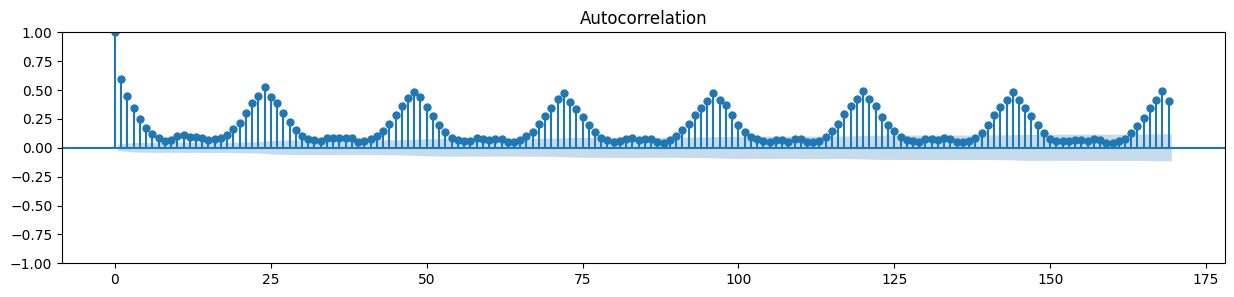

In [3]:
import statsmodels.api as sm

f, ax = plt.subplots(figsize=(15, 3))
autocorrelation = sm.graphics.tsa.plot_acf(df['User5'][:10000].values, lags=169, alpha=0.01, ax=ax)

### Weather Features

Explained Variance Ratio: [0.42321588]
Spearman:
temp    0.099129
rhum   -0.169928
dwpt   -0.011667
wdir    0.085684
wspd    0.144334
pres   -0.026937
PC1     0.149857
dtype: float64
Pearson:
temp    0.015216
rhum   -0.098750
dwpt   -0.073288
wdir    0.067134
wspd    0.087345
pres    0.003287
PC1     0.077930
dtype: float64


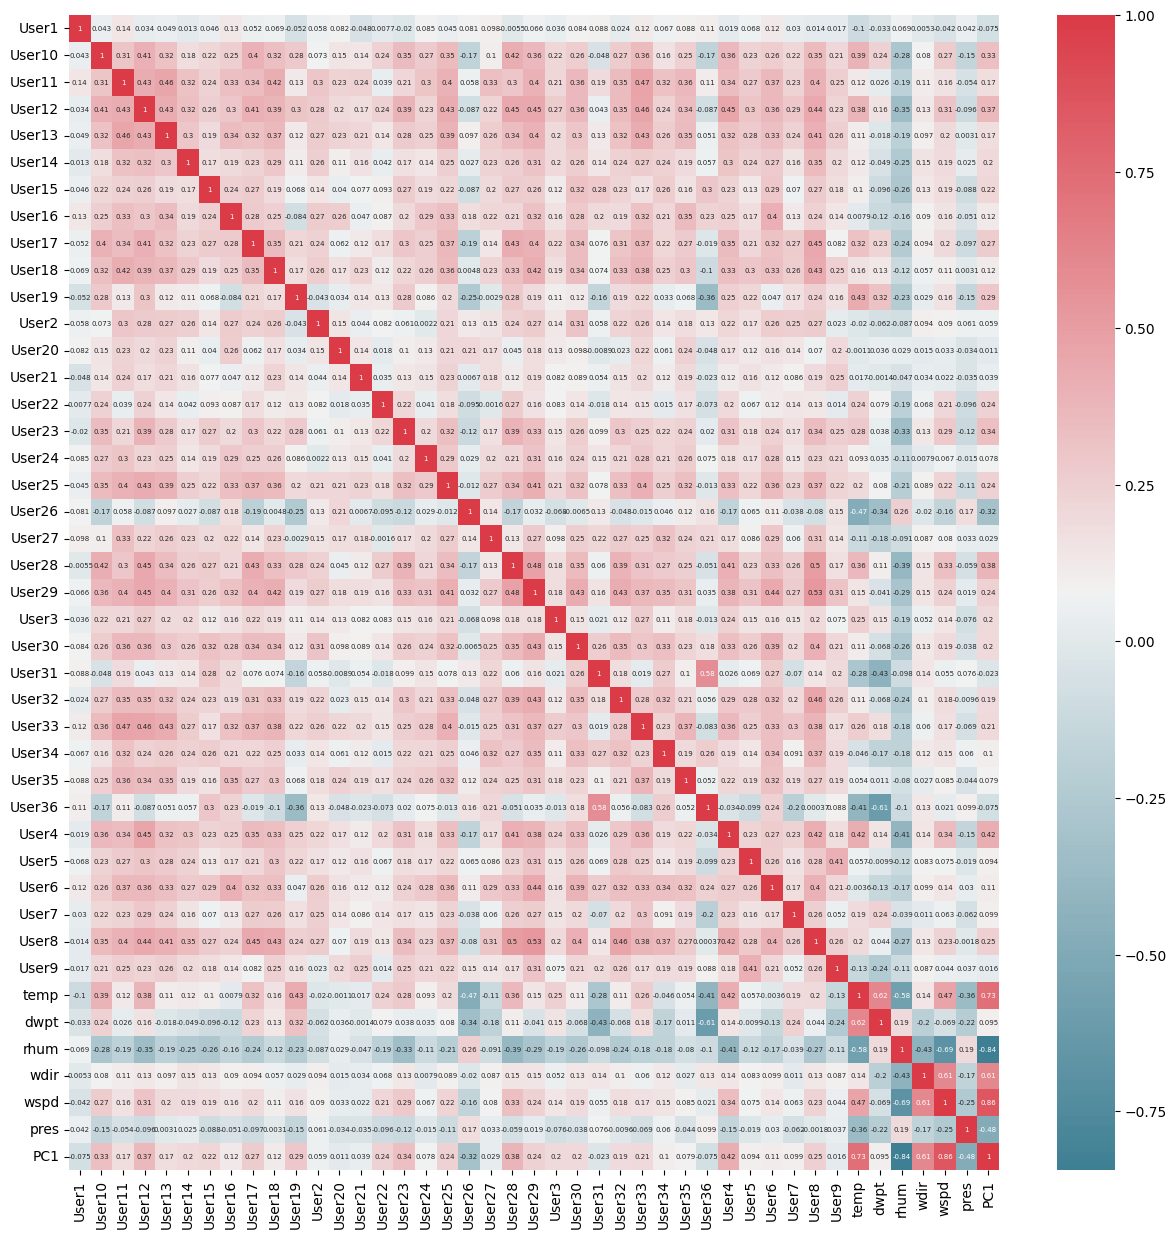

In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

n_components = 1  # Replace with the number of components you want

# Load your DataFrame or replace this with your data loading code
# For example: df = pd.read_csv('your_data.csv')

# Extract the weather features from your DataFrame
weather_features = df[['temp', 'rhum', 'dwpt', 'wdir', 'wspd', 'pres']]

# Standardize the data
scaler = StandardScaler()
scaled_weather_features = scaler.fit_transform(weather_features)

# Create a PCA instance with the desired number of components

pca = PCA(n_components=n_components)

# Fit and transform the scaled data using PCA
principal_components = pca.fit_transform(scaled_weather_features)

# Create a DataFrame to store the principal components
pc_df = pd.DataFrame(data=principal_components, index=df.index, columns=[f'PC{i+1}' for i in range(n_components)])

# Add the principal components back to your original DataFrame if needed
df_with_pcs = pd.concat([df, pc_df], axis=1, )

# Explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_var_ratio)

f, ax = plt.subplots(figsize=(15, 15))

#Compute pairwise correlation of columns, excluding NA/null values.
corr_spearman = df_with_pcs.corr(method="spearman")
corr_pearson = df_with_pcs.corr(method="pearson")
#Plot heatmap, use _ to hide instance output
#
_ = sns.heatmap(data=corr_spearman, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), #color map
            square=False, 
            annot=True,
            annot_kws={"size": 5}
            )

# Select the columns you want to calculate the average for
selected_columns = ['temp', 'rhum', 'dwpt', 'wdir', 'wspd', 'pres', 'PC1']

# Calculate the average over all users for the selected columns
average_spearman_corr_over_all_users_weather = corr_spearman[selected_columns].iloc[:36].mean()
average_pearson_corr_over_all_users_weather = corr_pearson[selected_columns].iloc[:36].mean()

print("Spearman:")
print(average_spearman_corr_over_all_users_weather)
print("Pearson:")
print(average_pearson_corr_over_all_users_weather)

In [4]:
df = df_with_pcs.drop(['dwpt', 'wdir', 'pres'], axis=1)
df.head(3)

,User1,User10,User11,User12,User13,User14,User15,User16,User17,User18,...,User4,User5,User6,User7,User8,User9,temp,rhum,wspd,PC1
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,0.068,0.703,0.353,0.210,0.138,0.208,0.065,0.340,0.129,0.576,...,0.090,0.098,0.636,0.106,0.156,0.012,5.1,96.0,0.0,-2.232616
2012-07-01 01:00:00,0.786,0.036,0.547,0.197,0.343,0.176,0.067,0.508,0.121,0.128,...,0.084,0.098,0.253,0.098,0.151,0.022,5.1,96.0,0.0,-2.232616
2012-07-01 02:00:00,0.544,0.045,0.519,0.163,0.339,0.164,0.057,0.542,0.141,0.098,...,0.084,0.075,0.220,0.089,0.152,0.023,5.1,96.0,0.0,-2.232616


### Time Features

Spearman:
hour                 0.347045
dayofweek            0.031434
month               -0.006063
year                -0.013343
hour sin            -0.321923
hour cos            -0.073418
Hour sin cos        -0.271447
dayofweek sin       -0.032741
dayofweek cos       -0.005933
dayofweek sin cos   -0.005933
dtype: float64
Pearson:
hour                 0.270925
dayofweek            0.028281
month               -0.000659
year                -0.024381
hour sin            -0.256359
hour cos            -0.016212
Hour sin cos        -0.192737
dayofweek sin       -0.032582
dayofweek cos        0.005024
dayofweek sin cos    0.005024
dtype: float64


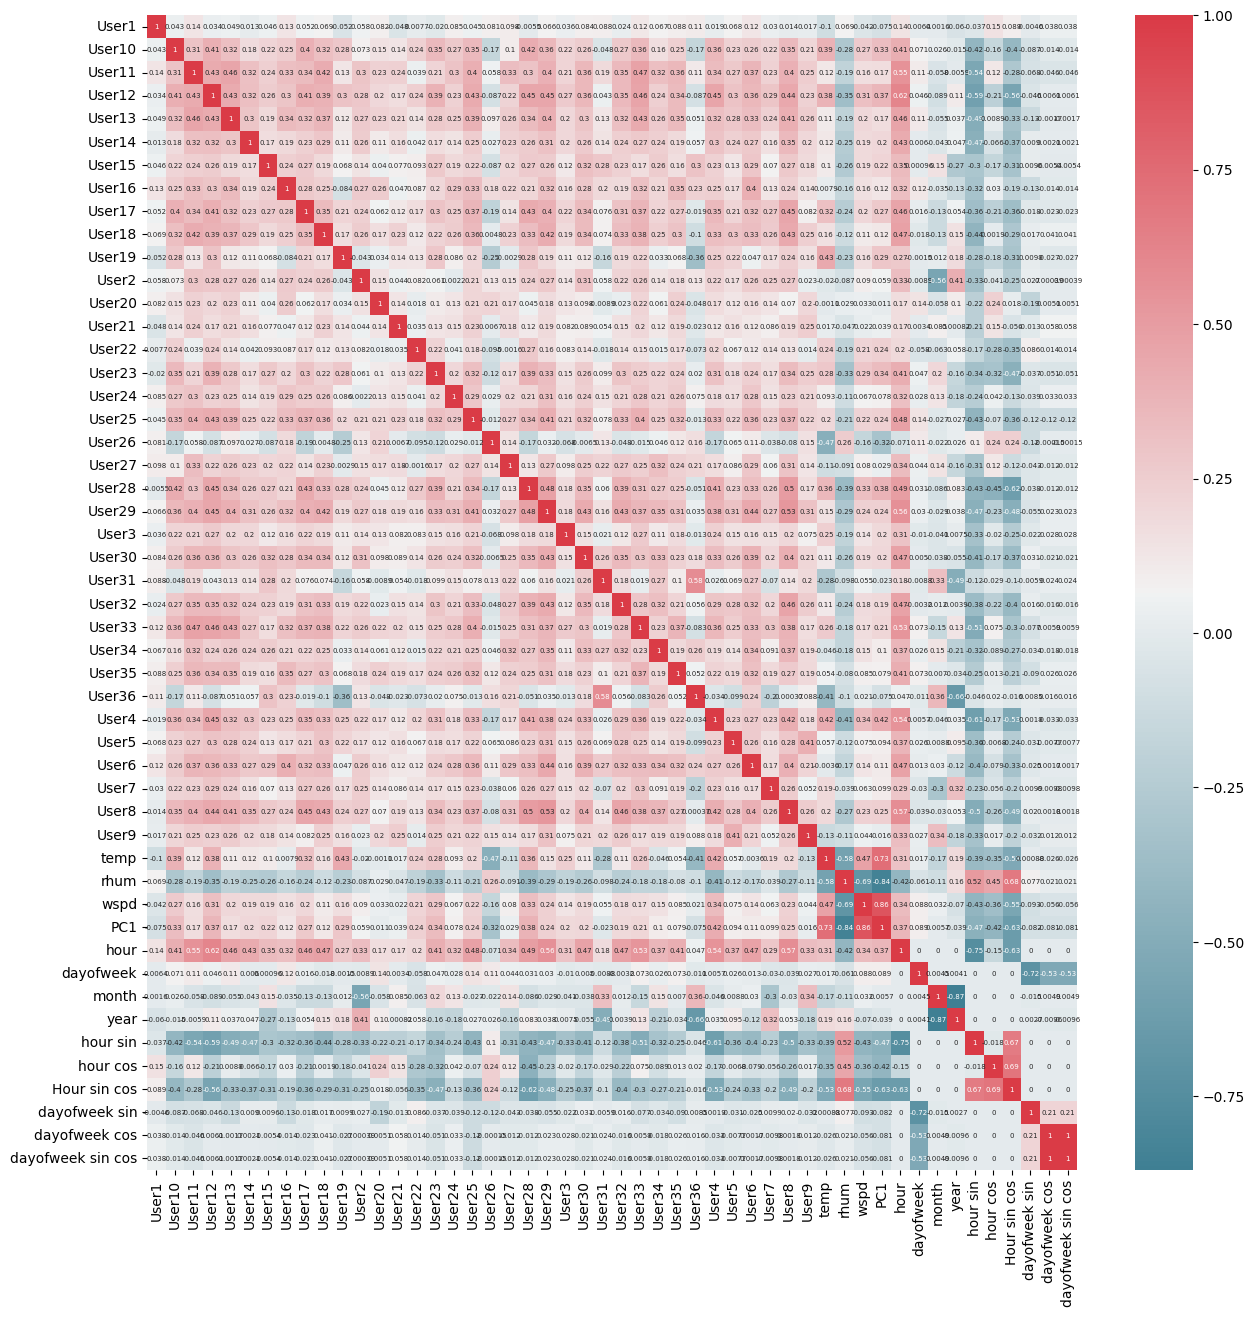

In [5]:
#Time Feature Engineering
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

# Perform sine-cosine scaling on 'hour' and 'dayofweek'
#One Sin/ cos cycle takes 2*pi
df['hour sin'] = np.sin((df['hour']/24)*2 * np.pi)
df['hour cos'] = np.cos((df['hour']/24)*2 * np.pi)
df['Hour sin cos'] = np.sin((df['hour']/24)*2 * np.pi) + np.cos((df['hour']/24)*2 * np.pi)
df['dayofweek sin'] = np.sin((df['dayofweek']/7)*2 * np.pi)
df['dayofweek cos'] = np.cos((df['dayofweek']/7)*2 * np.pi)
df['dayofweek sin cos'] = np.cos((df['dayofweek']/7)*2 * np.pi) + np.cos((df['dayofweek']/7)*2 * np.pi)

f, ax = plt.subplots(figsize=(15, 15))
#Compute pairwise correlation of columns, excluding NA/null values.
corr_spearman = df.corr(method="spearman")
corr_pearson = df.corr(method="pearson")
#Plot heatmap, use _ to hide instance output
#
_ = sns.heatmap(data=corr_spearman, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), #color map
            square=False, 
            annot=True,
            annot_kws={"size": 5}
            )

selected_columns = ['hour', 'dayofweek', 'month', 'year', 'hour sin', 'hour cos', 'Hour sin cos', 'dayofweek sin', 'dayofweek cos', 'dayofweek sin cos']

# Calculate the average over all users for the selected columns
average_spearman_corr_over_all_users_time = corr_spearman[selected_columns].iloc[:40].mean()
average_pearson_corr_over_all_users_time = corr_pearson[selected_columns].iloc[:36].mean()

print("Spearman:")
print(average_spearman_corr_over_all_users_time)
print("Pearson:")
print(average_pearson_corr_over_all_users_time)

In [6]:
df = df.drop(['hour', 'dayofweek', 'month', 'year', 'Hour sin cos', 'dayofweek sin', 'dayofweek cos', 'dayofweek sin cos'], axis=1)
df.head(3)

,User1,User10,User11,User12,User13,User14,User15,User16,User17,User18,...,User6,User7,User8,User9,temp,rhum,wspd,PC1,hour sin,hour cos
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,0.068,0.703,0.353,0.210,0.138,0.208,0.065,0.340,0.129,0.576,...,0.636,0.106,0.156,0.012,5.1,96.0,0.0,-2.232616,0.000000,1.000000
2012-07-01 01:00:00,0.786,0.036,0.547,0.197,0.343,0.176,0.067,0.508,0.121,0.128,...,0.253,0.098,0.151,0.022,5.1,96.0,0.0,-2.232616,0.258819,0.965926
2012-07-01 02:00:00,0.544,0.045,0.519,0.163,0.339,0.164,0.057,0.542,0.141,0.098,...,0.220,0.089,0.152,0.023,5.1,96.0,0.0,-2.232616,0.500000,0.866025


### Lag Features for Electricity Consumption

In [13]:
# Specify the User columns
user_columns = ['User1', 'User10', 'User11', 'User12', 'User13', 'User14', 'User15',
                'User16', 'User17', 'User18', 'User19', 'User2', 'User20', 'User21',
                'User22', 'User23', 'User24', 'User25', 'User26', 'User27', 'User28',
                'User29', 'User3', 'User30', 'User31', 'User32', 'User33', 'User34',
                'User35', 'User36', 'User4', 'User5', 'User6', 'User7', 'User8', 'User9']

# Specify the lag intervals in hours
lag_intervals = [24, 48, 78, 96, 120, 144, 168]

df_new = df

# Iterate through each user column and add lagged features
for user_col in user_columns:
    for lag in lag_intervals:
        # Create a new column with the lagged values
        lag_col_name = f"{user_col}_lag_{lag}hrs"
        df_new[lag_col_name] = df_new[user_col].shift(lag)

# Drop rows with NaN values created by the lagged features
df_new.dropna(inplace=True)
df_new[['User1', 'User1_lag_24hrs', 'User1_lag_48hrs', 'User1_lag_78hrs', 'User1_lag_96hrs', 'User1_lag_120hrs', 'User1_lag_144hrs', 'User1_lag_168hrs']].tail(30)

,User1,User1_lag_24hrs,User1_lag_48hrs,User1_lag_78hrs,User1_lag_96hrs,User1_lag_120hrs,User1_lag_144hrs,User1_lag_168hrs
Date,,,,,,,,
2013-06-29 18:00:00,0.352,0.273,0.224,0.235,0.896,0.403,0.775,1.111
2013-06-29 19:00:00,0.580,0.213,0.196,0.053,0.228,0.214,0.282,0.263
2013-06-29 20:00:00,0.182,0.184,0.210,0.346,0.211,0.481,0.270,0.257
2013-06-29 21:00:00,0.191,0.263,0.208,1.036,0.195,0.266,0.243,0.245
2013-06-29 22:00:00,0.445,0.265,0.121,1.568,0.316,0.113,0.253,0.157
2013-06-29 23:00:00,0.145,0.448,0.189,0.385,0.731,0.127,0.389,0.120
2013-06-30 00:00:00,0.631,0.100,0.528,0.571,0.029,0.128,0.057,0.919
2013-06-30 01:00:00,0.111,0.526,0.077,0.255,0.865,0.047,0.854,0.059
2013-06-30 02:00:00,0.109,0.124,0.070,0.240,0.857,0.037,0.138,0.060


Spearman:
User1               0.143355
User1_lag_24hrs     0.143222
User1_lag_48hrs     0.145286
User1_lag_78hrs     0.017363
User1_lag_96hrs     0.145941
User1_lag_120hrs    0.141970
User1_lag_144hrs    0.141470
User1_lag_168hrs    0.142341
User2               0.283886
User2_lag_24hrs     0.287196
User2_lag_48hrs     0.286192
User2_lag_78hrs     0.205231
User2_lag_96hrs     0.287140
User2_lag_120hrs    0.288375
User2_lag_144hrs    0.286865
User2_lag_168hrs    0.282328
User3               0.127965
User3_lag_24hrs     0.127918
User3_lag_48hrs     0.130056
User3_lag_78hrs     0.071975
User3_lag_96hrs     0.129844
User3_lag_120hrs    0.134204
User3_lag_144hrs    0.133792
User3_lag_168hrs    0.132486
dtype: float64
Pearson:
User1               0.156592
User1_lag_24hrs     0.157878
User1_lag_48hrs     0.159673
User1_lag_78hrs     0.052601
User1_lag_96hrs     0.161142
User1_lag_120hrs    0.158989
User1_lag_144hrs    0.158709
User1_lag_168hrs    0.155717
User2               0.170137
User2_lag

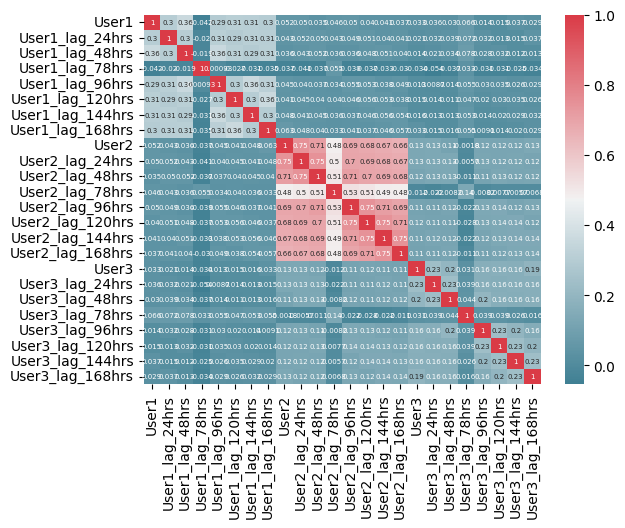

In [15]:
selected_columns = [
    'User1', 'User1_lag_24hrs', 'User1_lag_48hrs', 'User1_lag_78hrs', 'User1_lag_96hrs', 'User1_lag_120hrs', 'User1_lag_144hrs', 'User1_lag_168hrs',
    'User2', 'User2_lag_24hrs', 'User2_lag_48hrs', 'User2_lag_78hrs', 'User2_lag_96hrs', 'User2_lag_120hrs', 'User2_lag_144hrs', 'User2_lag_168hrs',
    'User3', 'User3_lag_24hrs', 'User3_lag_48hrs', 'User3_lag_78hrs', 'User3_lag_96hrs', 'User3_lag_120hrs', 'User3_lag_144hrs', 'User3_lag_168hrs',
]

df_corr = df_new[selected_columns]

#Compute pairwise correlation of columns, excluding NA/null values.
corr_spearman = df_corr.corr(method="spearman")
corr_pearson = df_corr.corr(method="pearson")
#Plot heatmap, use _ to hide instance output
#
_ = sns.heatmap(data=corr_spearman, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), #color map
            square=False, 
            annot=True,
            annot_kws={"size": 5}
            )

average_spearman_corr_over_all_users_lag = corr_spearman[selected_columns].iloc[:40].mean()
average_pearson_corr_over_all_users_lag = corr_pearson[selected_columns].iloc[:40].mean()

print("Spearman:")
print(average_spearman_corr_over_all_users_lag)
print("Pearson:")
print(average_pearson_corr_over_all_users_lag)

In [17]:
print("Spearman - weather:")
print(average_spearman_corr_over_all_users_weather)
print("Pearson - weather:")
print(average_pearson_corr_over_all_users_weather)

Spearman - weather:
temp    0.099129
rhum   -0.169928
dwpt   -0.011667
wdir    0.085684
wspd    0.144334
pres   -0.026937
PC1     0.149857
dtype: float64
Pearson - weather:
temp    0.015216
rhum   -0.098750
dwpt   -0.073288
wdir    0.067134
wspd    0.087345
pres    0.003287
PC1     0.077930
dtype: float64
Spearman - time: 
hour                 0.347045
dayofweek            0.031434
month               -0.006063
year                -0.013343
hour sin            -0.321923
hour cos            -0.073418
Hour sin cos        -0.271447
dayofweek sin       -0.032741
dayofweek cos       -0.005933
dayofweek sin cos   -0.005933
dtype: float64
Pearson - time:
hour                 0.270925
dayofweek            0.028281
month               -0.000659
year                -0.024381
hour sin            -0.256359
hour cos            -0.016212
Hour sin cos        -0.192737
dayofweek sin       -0.032582
dayofweek cos        0.005024
dayofweek sin cos    0.005024
dtype: float64
Spearman - lag:
User1        

In [18]:
print("Spearman - time: ")
print(average_spearman_corr_over_all_users_time)
print("Pearson - time:")
print(average_pearson_corr_over_all_users_time)

Spearman - time: 
hour                 0.347045
dayofweek            0.031434
month               -0.006063
year                -0.013343
hour sin            -0.321923
hour cos            -0.073418
Hour sin cos        -0.271447
dayofweek sin       -0.032741
dayofweek cos       -0.005933
dayofweek sin cos   -0.005933
dtype: float64
Pearson - time:
hour                 0.270925
dayofweek            0.028281
month               -0.000659
year                -0.024381
hour sin            -0.256359
hour cos            -0.016212
Hour sin cos        -0.192737
dayofweek sin       -0.032582
dayofweek cos        0.005024
dayofweek sin cos    0.005024
dtype: float64


In [19]:
print("Spearman - lag:")
print(average_spearman_corr_over_all_users_lag)
print("Pearson - lag:")
print(average_pearson_corr_over_all_users_lag)

Spearman - lag:
User1               0.143355
User1_lag_24hrs     0.143222
User1_lag_48hrs     0.145286
User1_lag_78hrs     0.017363
User1_lag_96hrs     0.145941
User1_lag_120hrs    0.141970
User1_lag_144hrs    0.141470
User1_lag_168hrs    0.142341
User2               0.283886
User2_lag_24hrs     0.287196
User2_lag_48hrs     0.286192
User2_lag_78hrs     0.205231
User2_lag_96hrs     0.287140
User2_lag_120hrs    0.288375
User2_lag_144hrs    0.286865
User2_lag_168hrs    0.282328
User3               0.127965
User3_lag_24hrs     0.127918
User3_lag_48hrs     0.130056
User3_lag_78hrs     0.071975
User3_lag_96hrs     0.129844
User3_lag_120hrs    0.134204
User3_lag_144hrs    0.133792
User3_lag_168hrs    0.132486
dtype: float64
Pearson - lag:
User1               0.156592
User1_lag_24hrs     0.157878
User1_lag_48hrs     0.159673
User1_lag_78hrs     0.052601
User1_lag_96hrs     0.161142
User1_lag_120hrs    0.158989
User1_lag_144hrs    0.158709
User1_lag_168hrs    0.155717
User2               0.1701

In [ ]:
cwd = os.path.normpath(os.getcwd())

#df_new.to_csv(cwd+'/data/df_with_all_potential_features.csv')